In [33]:
!pip install yfinance --quiet

In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime, date

In [35]:
# =========================
# 1. パラメータ設定
# =========================

STOCK_TICKERS = [
    "7203.T",  # トヨタ
    "6758.T",  # ソニーG
    "9433.T",  # KDDI
]

START = "2010-01-01"
END   = None

ROLL_WINDOW = 250   # 日次なら250=1年
MIN_OBS_ROLL = 120  # 最低観測数
MIN_OBS_AR1  = 120

In [36]:
# =========================
# 2. Stooq TOPIX を取得
# =========================

def get_stooq_topix(start_str, end_str=None):
    start = datetime.strptime(start_str, "%Y-%m-%d").date()
    end = date.today() if end_str is None else datetime.strptime(end_str, "%Y-%m-%d").date()

    df = web.DataReader("^TPX", "stooq", start, end)
    df = df.sort_index()
    return df[["Close"]].rename(columns={"Close": "TOPIX"})

In [37]:
# =========================
# 3. yfinance 調整済み株価
# =========================

def get_adj_close(tickers, start, end=None):
    data = yf.download(
        tickers,
        start=start,
        end=end,
        auto_adjust=True,
        progress=False
    )

    if isinstance(data.columns, pd.MultiIndex):
        if "Adj Close" in data.columns.get_level_values(0):
            return data["Adj Close"]
        return data[data.columns.levels[0][0]]

    if "Adj Close" in data.columns:
        return data["Adj Close"].to_frame(name=tickers)
    return data["Close"].to_frame(name=tickers)


# 個別株
stock_prices = get_adj_close(STOCK_TICKERS, START, END)
# TOPIX
market_price = get_stooq_topix(START, END)

print(stock_prices.columns)
print(market_price.columns)

Index(['6758.T', '7203.T', '9433.T'], dtype='object', name='Ticker')
Index(['TOPIX'], dtype='object')


In [38]:
# =========================
# 4. 日次リターン（ここが月次→日次に変更！）
# =========================

stk_ret = stock_prices.pct_change()
mkt_ret = market_price["TOPIX"].pct_change()

# 日付合わせ
idx = stk_ret.index.intersection(mkt_ret.index)
stk_ret = stk_ret.loc[idx]
mkt_ret = mkt_ret.loc[idx]

factors = pd.DataFrame({"Mkt": mkt_ret})

In [39]:
# =========================
# 5. 日次ローリングCAPM → 毎日 α を推定
# =========================

def rolling_alpha_panel(excess_ret, factors, window=250, min_obs=120):

    X_all = sm.add_constant(factors)
    alphas = pd.DataFrame(index=excess_ret.index, columns=excess_ret.columns)

    for stock in excess_ret.columns:
        y = excess_ret[stock]

        for t in range(window - 1, len(y)):
            y_win = y.iloc[t-window+1:t+1]
            X_win = X_all.iloc[t-window+1:t+1]

            df_valid = pd.concat([y_win, X_win], axis=1).dropna()
            if len(df_valid) < min_obs:
                continue

            model = sm.OLS(df_valid.iloc[:, 0], df_valid.iloc[:, 1:]).fit()
            alphas.loc[y.index[t], stock] = model.params["const"]

    return alphas


alpha_panel = rolling_alpha_panel(stk_ret, factors,
                                  window=ROLL_WINDOW,
                                  min_obs=MIN_OBS_ROLL)

print("日次α末尾：")
display(alpha_panel.tail())

日次α末尾：


Ticker,6758.T,7203.T,9433.T
Date,,,
2025-12-04,0.000528,-0.000301,0.000067
2025-12-05,0.000443,-0.000351,0.000107
2025-12-08,0.000275,-0.000241,0.000095
2025-12-09,0.000273,-0.000248,0.000065
2025-12-10,0.000205,-0.000115,0.000105


In [40]:
# =========================
# 6. AR(1) φ（持続性）推定
# =========================

def estimate_ar1_phi(series, min_obs=120):
    """
    α_t = c + φ α_{t-1} + e_t の φ を OLS で推定
    """
    # 数値として扱えるものだけ float にキャスト
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) < min_obs:
        return np.nan

    y = s.iloc[1:]
    x = s.shift(1).iloc[1:]

    # 念のためここでも numeric に揃えておく
    y = pd.to_numeric(y, errors="coerce")
    x = pd.to_numeric(x, errors="coerce")

    valid = pd.concat([y, x], axis=1).dropna()
    if len(valid) < min_obs:
        return np.nan

    y_clean = valid.iloc[:, 0].astype(float).values
    x_clean = valid.iloc[:, 1].astype(float).values

    X = sm.add_constant(x_clean)
    model = sm.OLS(y_clean, X).fit()

    # x の係数（φ）だけ返す
    return model.params[1]  # params[0]=const, params[1]=phi

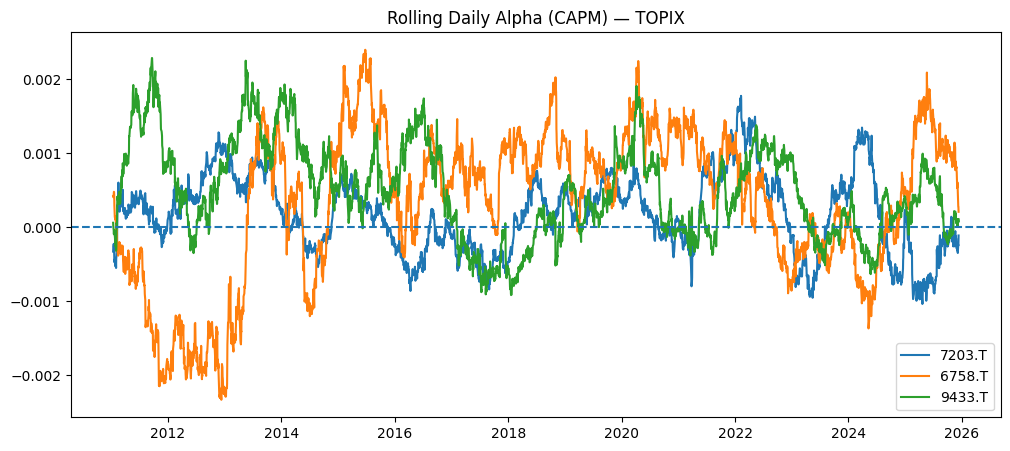

In [41]:
# =========================
# 7. 日次αプロット
# =========================

plt.figure(figsize=(12,5))
for stock in STOCK_TICKERS:
    plt.plot(alpha_panel[stock], label=stock)

plt.axhline(0, ls="--")
plt.title("Rolling Daily Alpha (CAPM) — TOPIX")
plt.legend()
plt.show()

In [42]:
# =========================
# small cap 用の銘柄リスト
# =========================

small_candidates = [
    "4443.T",
    "7359.T",
    "4192.T",
    "4375.T",
    "2934.T",
    "6613.T",
    "3491.T",
    "6081.T",
    "3182.T",
    "3134.T",
    "4385.T",
    "7095.T",
    "4884.T",
    "4593.T",
]


In [44]:
# ここから先は「大型株3銘柄版」とほぼ同じ処理を small_candidates に対して実行

STOCK_TICKERS = small_candidates

# 株価ダウンロード
stock_prices = get_adj_close(STOCK_TICKERS, START, END)
stock_prices = stock_prices.dropna(axis=1, how="all")  # 全部NaNの銘柄は落とす

# TOPIX（既に market_price を作っているならこの行は飛ばしてOK）
market_price = get_stooq_topix(START, END)

print("small stocks:", stock_prices.columns)
print("TOPIX:", market_price.columns)

small stocks: Index(['2934.T', '3134.T', '3182.T', '3491.T', '4192.T', '4375.T', '4385.T',
       '4443.T', '4593.T', '4884.T', '6081.T', '6613.T', '7095.T', '7359.T'],
      dtype='object', name='Ticker')
TOPIX: Index(['TOPIX'], dtype='object')


In [45]:
# 日次リターン
stk_ret = stock_prices.pct_change()
mkt_ret = market_price["TOPIX"].pct_change()

# 日付合わせ
idx = stk_ret.index.intersection(mkt_ret.index)
stk_ret = stk_ret.loc[idx]
mkt_ret = mkt_ret.loc[idx]

factors = pd.DataFrame({"Mkt": mkt_ret})

# ローリングCAPM（日次 α）
alpha_panel_small = rolling_alpha_panel(
    excess_ret=stk_ret,
    factors=factors,
    window=ROLL_WINDOW,
    min_obs=MIN_OBS_ROLL
)

print("small cap 日次α末尾：")
display(alpha_panel_small.tail())

small cap 日次α末尾：


Ticker,2934.T,3134.T,3182.T,3491.T,4192.T,4375.T,4385.T,4443.T,4593.T,4884.T,6081.T,6613.T,7095.T,7359.T
Date,,,,,,,,,,,,,,
2025-12-04,-0.001941,-0.002091,-0.000958,0.001654,-0.001571,-0.000935,0.000858,-0.001108,0.003397,-0.003477,0.002317,-0.000522,-0.002086,0.000244
2025-12-05,-0.001893,-0.002156,-0.000904,0.001629,-0.001499,-0.000927,0.001131,-0.001274,0.003546,-0.003465,0.001449,-0.000514,-0.002047,0.000419
2025-12-08,-0.001989,-0.001952,-0.000919,0.001681,-0.001456,-0.001057,0.001117,-0.001321,0.003431,-0.003551,0.001337,-0.000416,-0.002022,-0.0004
2025-12-09,-0.001194,-0.001904,-0.000854,0.001644,-0.00144,-0.000997,0.001032,-0.001332,0.003506,-0.003398,0.001004,-0.000632,-0.001994,-0.000107
2025-12-10,-0.001426,-0.001881,-0.000808,0.001726,-0.001138,-0.00105,0.001066,-0.001467,0.002733,-0.003313,0.000529,-0.000528,-0.001964,-0.000036


In [46]:
# AR(1) φ & half-life（日次）
phi_dict = {}
hl_dict  = {}

for stock in alpha_panel_small.columns:
    phi = estimate_ar1_phi(alpha_panel_small[stock], min_obs=MIN_OBS_AR1)
    phi_dict[stock] = phi
    if pd.notna(phi) and 0 < phi < 1:
        hl_dict[stock] = np.log(0.5) / np.log(phi)  # 営業日ベース
    else:
        hl_dict[stock] = np.nan

phi_small = pd.DataFrame({
    "phi": phi_dict,
    "half_life_days": hl_dict
})

print("small cap の AR(1) φ & 半減期（日数）：")
display(phi_small)

small cap の AR(1) φ & 半減期（日数）：


,phi,half_life_days
2934.T,0.992472,91.724002
3134.T,0.996341,189.103437
3182.T,0.996790,215.616283
3491.T,0.992550,92.687236
4192.T,0.989344,64.701203
4375.T,0.994085,116.830512
4385.T,0.994983,137.825019
4443.T,0.992630,93.706111
4593.T,0.997243,251.039347
4884.T,0.994247,120.140858


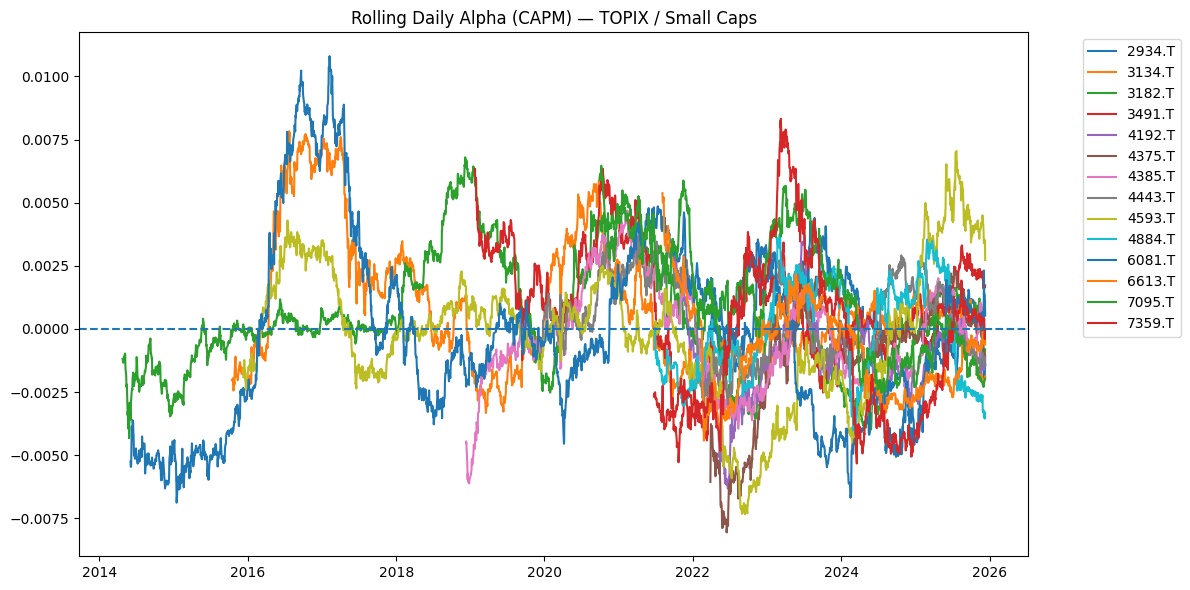

In [47]:
# α推移プロット（銘柄多いので注意）
plt.figure(figsize=(12,6))
for stock in alpha_panel_small.columns:
    plt.plot(alpha_panel_small.index, alpha_panel_small[stock], label=stock)

plt.axhline(0, ls="--")
plt.title("Rolling Daily Alpha (CAPM) — TOPIX / Small Caps")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()